In [4]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import dill
import dask, dask_ml
import dask.dataframe as dd
import ast

from importlib import reload
from scipy import signal, stats
from tqdm.auto import tqdm
from sklearn import neighbors, linear_model, ensemble, decomposition #svm, neural_network
from sklearn import feature_selection, model_selection, metrics, dummy, pipeline, preprocessing, compose
from sklearn.base import clone
from dask_ml.model_selection import RandomizedSearchCV
from matplotlib import pyplot as plt
from src import main, feature_model
from itertools import product

In [6]:
from dask_jobqueue import SLURMCluster
from distributed import Client, LocalCluster

In [7]:
try:
    cluster.close()
    client.close()
except NameError:
    pass
finally:
#     Uncomment for SLURM execution
#     cluster = SLURMCluster(queue='short', 
#                            cores=4, 
#                            memory='10gB', 
#                            walltime='1:00:00', 
#                            death_timeout=60, 
#                           )
#     cluster.adapt(minimum=1, maximum=100)
    cluster = LocalCluster()
    client = Client(cluster)
    cluster.adapt(minimum=0, maximum=3)

# Load data

In [9]:
label_cols = ['on_off', 'dyskinesia', 'tremor', 'subject_id']
id_cols = ['measurement_id', 'samp_id', 'id']

labels = pd.concat([
    pd.read_csv('data/cis-pd/data_labels/CIS-PD_Training_Data_IDs_Labels.csv'),
    pd.read_csv('data/real-pd/data_labels/REAL-PD_Training_Data_IDs_Labels.csv'),
], axis=0).astype({'subject_id': str})
subj_means = labels.groupby('subject_id').mean()

In [14]:
# These features don't compute for a number of observations
drop_cols = ['rms__friedrich_coefficients__m_3__r_30__coeff_0',
       'rms__friedrich_coefficients__m_3__r_30__coeff_1',
       'rms__friedrich_coefficients__m_3__r_30__coeff_2',
       'rms__friedrich_coefficients__m_3__r_30__coeff_3',
       'rms__max_langevin_fixed_point__m_3__r_30']
# These fft features are null for our size of windows
null_fft_cols = ['rms__fft_coefficient__coeff_%d__attr_"%s"' % (n, s) 
                     for n, s in product(range(51, 100), ['abs', 'angle', 'imag', 'real'])]
# Sample entropy can take inf which screws with models
inf_cols = ['rms__sample_entropy']

In [62]:
dataset = 'cis-tsfeatures'
features_df = dd.read_parquet(f'extracted_features/ensem/{dataset}.parquet')

df = features_df.drop(columns=[*drop_cols, *null_fft_cols, *inf_cols]).dropna().merge(labels, right_on='measurement_id', left_on='samp_id')
print('%d rows dropped due to nans in features' % (features_df.shape[0] - df.shape[0]).compute())

dfc = client.persist(df)

0 rows dropped due to nans in features


# Model

## Model spec

In [8]:
scaler = preprocessing.RobustScaler(quantile_range=(1, 99))
scaler_pg = {'scaler__quantile_range': [(.1, 99.9), (.5, 99.5), (1, 99), (5, 95), (10, 90)],}

# Keep features w/ variance in top x%ile 
var = lambda X, y: np.var(X, axis=0)
f_select = feature_selection.SelectPercentile(var, percentile=95)
f_select_pg = {'f_select__percentile': stats.uniform(0, 100)}

model = ensemble.RandomForestRegressor()
model_pg = {'model__regressor__n_estimators': stats.randint(50, 100), 'model__regressor__max_depth': stats.randint(10, 25), 'model__regressor__max_features': [.25, 'auto']}

clip_out = preprocessing.FunctionTransformer(np.clip, kw_args={'a_min': 0, 'a_max': 4})
clipped_model = compose.TransformedTargetRegressor(regressor=model, inverse_func=clip_out.transform)

pipe = pipeline.Pipeline([
    ('scaler', scaler), 
    ('f_select', f_select), 
    ('model', clipped_model),
], verbose=1)

param_grid = {
    **scaler_pg,
    **f_select_pg,
    **model_pg,
}

metric = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)

cv = model_selection.StratifiedKFold(shuffle=True)

## Model eval

In [ ]:
cis_subjs = ['1004', '1006', '1007', '1019', '1020', '1023', '1032', '1034', '1038', '1039', '1043', '1044', '1046', '1048', '1049', '1051',]
real_subjs = ['hbv013', 'hbv038', 'hbv017', 'hbv023', 'hbv051', 'hbv077', 'hbv054', 'hbv014', 'hbv018', 'hbv043', 'hbv022', 'hbv012',]

# To run for REAL-PD, change above value of dataset to 'real_watch_accel-tsfeatures', and iterate over real_subjs instead
for subj in cis_subjs:
    print(f'<{subj}>')
    subj_df = df[df.subject_id == subj]
    subj_df = client.persist(subj_df)
    
    for label in ['dyskinesia', 'on_off', 'tremor']:
        print(f'working on {label}')

        id_cols = ['measurement_id', 'samp_id', 'id']
        labeled_samps = subj_df.dropna(subset=[label])
        if not labeled_samps.shape[0].compute(): 
            print(f'skipping {label}')
            continue 

        y = subj_df.loc[labeled_samps.index, label].astype('int')
        X = labeled_samps.drop(columns=[*label_cols, *id_cols])

        search = RandomizedSearchCV(pipe, param_grid, n_iter=20, scoring=metric, cv=cv, refit=False, scheduler=client)
        cv_fit = search.fit(X, y)
        cv_results = pd.DataFrame(cv_fit.cv_results_)

        resultset_name = f'{dataset}_subj-{subj}_{type(model).__name__}_{label}'
        cv_results.to_csv(f'performance/cv_paramsweeps/{resultset_name}.csv')
        win_params = cv_results.loc[cv_results.rank_test_score == 1, 'params'].values[0]
        winner = pipe.set_params(**win_params)
        with open(f'models/paramsweep_winners/{resultset_name}.model', 'wb') as f:
            dill.dump(winner, f)
        print(f'done with {label}')
        
    try:
        cluster.close()
        client.close()
    except NameError:
        pass
    finally:
        cluster = SLURMCluster(queue='short', 
                               cores=4, 
                               memory='8gB', 
                               walltime='1:00:00', 
                               death_timeout=60, 
                              )
        client = Client(cluster)
        cluster.adapt(minimum=1, maximum=200, wait_count=5)
        
    print(f'</{subj}>')

## Single train-test split for evaluation

In [47]:
import ast

cv_results = pd.read_csv(f'performance/cv_paramsweeps/{dataset}_subj-{subj}_{type(model).__name__}_{label}.csv')
win_params = ast.literal_eval(cv_results.loc[cv_results.rank_test_score == 1, 'params'].values[0])
winner = pipe.set_params(**win_params)

In [101]:
X_c = X.compute().reset_index(drop=True)
y_c = y.compute().reset_index(drop=True)
samp_map = df.loc[:, 'samp_id'].compute().reset_index(drop=True)

x_train, x_test, y_train, y_test = model_selection.train_test_split(X_c, y_c, test_size=.25, stratify=y_c)

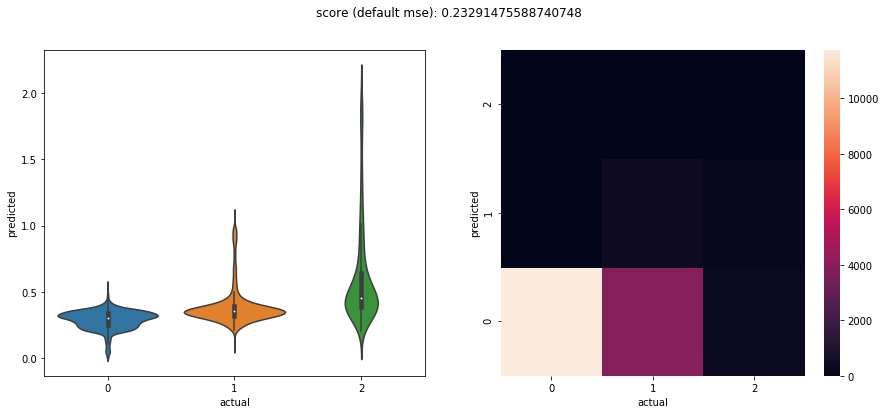

In [106]:
with joblib.parallel_backend('loky'):
    winner.fit(x_train, y_train)
    pred = winner.predict(x_test)

main.plot_performance(y_test, pred)

In [22]:
pd.Series(data=winner.named_steps['model'].regressor_.feature_importances_,
          index=X.columns[winner.named_steps['f_select'].get_support()]).sort_values().iloc[-20:]

rms__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0     0.006287
rms__quantile__q_0.7                                               0.006326
rms__cid_ce__normalize_False                                       0.006357
rms__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0    0.006506
rms__autocorrelation__lag_2                                        0.006634
rms__mean_abs_change                                               0.006706
rms__fft_aggregated__aggtype_"centroid"                            0.006899
rms__absolute_sum_of_changes                                       0.006959
rms__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2    0.007260
rms__quantile__q_0.6                                               0.007392
rms__partial_autocorrelation__lag_2                                0.007445
rms__fft_aggregated__aggtype_"kurtosis"                            0.007606
rms__autocorrelation__lag_3                                        0.007884
rms__quantil

###  Combine window predictions using mean

In [ ]:
# Ensemble prediction by taking mean of window predictions 
ensem_pred = pd.DataFrame({'samp_id': samp_map[y_test.index], 'pred': pred}).groupby('samp_id').median()
result = ensem_pred.join(labels.loc[labels.measurement_id.isin(ensem_pred.index)].set_index('measurement_id')[label])
main.plot_performance(result[label], result.pred)

# Baseline for reference

In [18]:
label = 'dyskinesia'
labeled_samps = df.dropna(subset=[label]).drop(columns=[*label_cols, *id_cols])

y = df.loc[labeled_samps.index, label].astype('int')
metric = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)

In [ ]:
# patient-specific mean predictor
X_subjs = labels[labels.measurement_id.isin(samp_map.unique())][['subject_id']]
actuals = labels[labels.measurement_id.isin(samp_map.unique())][label]
naive_pred = X_subjs.merge(subj_means[[label]], left_on='subject_id', right_index=True).rename(columns={label: 'prediction'})
main.plot_performance(actuals, naive_pred.prediction)

# Train final model params

In [71]:
def train_final_models(pair, dataset='foo', model=pipe, df=df):
    subj, label = pair
    try:
        cv_results = pd.read_csv(f'performance/cv_paramsweeps/{dataset}_subj-{subj}_RandomForestRegressor_{label}.csv')
    except FileNotFoundError:
        # Some subject/label combos don't exist
        return None
    
    model_params = ast.literal_eval(cv_results.loc[cv_results.rank_test_score == 1, 'params'].values[0])
    model = clone(pipe).set_params(**model_params)

    subj_df = df[df.subject_id == subj].dropna(subset=[label])
    y = subj_df[label].astype('int')
    X = subj_df.drop(columns=[*label_cols, *id_cols])
    
    with joblib.parallel_backend('loky'):
        model.fit(X, y)
        
    with open(f'models/paramsweep_winners/FINAL-{dataset}_subj-{subj}_RandomForestRegressor_{label}.model', 'wb') as f:
        dill.dump(model, f)
    return True

In [ ]:
cis_subjs = ['1004', '1006', '1007', '1019', '1020', '1023', '1032', '1034', '1038', '1039', '1043', '1044', '1046', '1048', '1049', '1051',]
real_subjs = ['hbv013', 'hbv038', 'hbv017', 'hbv023', 'hbv051', 'hbv077', 'hbv054', 'hbv014', 'hbv018', 'hbv043', 'hbv022', 'hbv012',]
label_vals = ['tremor', 'dyskinesia', 'on_off']

pairs = [*product(cis_subjs, label_vals)]

futures = client.map(train_final_models, pairs, dataset='cis-tsfeatures', df=dfc)

In [ ]:
failed_keys, failed_futures = list(zip(*[(cis_pairs[i], f) for i, f in [(i, f) for i, f in enumerate(futures) if (f.status == 'error') or (f.status == 'pending')]]))

In [91]:
client.cancel(futures)

In [72]:
futures = client.map(train_final_models, failed_keys, dataset='cis-tsfeatures')

# Predictions on test set

In [17]:
def load_final_model(subj, label):
    model_fp = f'models/final_fitted/FINAL_subj-{subj}_RandomForestRegressor_{label}.model'
    with open(model_fp, 'rb') as f:
        model = dill.load(f)
    return model

In [ ]:
label_vals = ['dyskinesia', 'tremor', 'on_off']
samp_preds = {l: [] for l in label_vals}

for label in tqdm(label_vals):
    test_samps = pd.read_csv(f'test_predictions/sub_template_{label}.csv', index_col=0).index
    test_features_df = pd.concat([
        pd.read_csv('extracted_features/ensem/cis_test-tsfeatures.csv'), 
        pd.read_csv('extracted_features/ensem/real_watch_accel_test-tsfeatures.csv')
    ])
    test_features_df = test_features_df[test_features_df.samp_id.isin(test_samps)].drop(columns=[*drop_cols, *null_fft_cols, *inf_cols])

    test_subjs = pd.concat([
        pd.read_csv('data/test_set/cis-pd/cis-pd.CIS-PD_Test_Data_IDs.csv', index_col=0), 
        pd.read_csv('data/test_set/real-pd/real-pd.REAL-PD_Test_Data_IDs.csv', index_col=0)
    ]).astype({'subject_id': str}).reindex(test_samps).reset_index()
    subjs = test_subjs.subject_id.unique()
    
    for subj in tqdm(subjs, leave=False):
        model = load_final_model(subj, label)
        samps = test_subjs.groupby('subject_id').get_group(subj)
        subj_samps = test_features_df[test_features_df.samp_id.isin(samps.measurement_id)]
        X = subj_samps.drop(columns=['id', 'samp_id']).dropna()
        d = subj_samps.shape[0] - X.shape[0]  
        if d:
            print(f'{label}-{subj} :: {d} samples dropped')
        samp_ids = subj_samps['samp_id'].reindex(X.index)

        window_pred = model.predict(X)
        pred_df = pd.DataFrame({'samp_id': samp_ids, 'pred': window_pred})
        samp_pred = pred_df.groupby('samp_id').median()
        samp_preds[label].append(samp_pred)
    
    samp_preds[label] = pd.concat(samp_preds[label]).rename(index={'samp_id':'measurement_id'}, columns={'pred': 'prediction'})
    nopred_obs = test_subjs[test_subjs.measurement_id.isin(test_samps.difference(samp_preds[label].index))]
    nopred_predictions = nopred_obs.join(subj_means, on='subject_id').set_index('measurement_id')[[label]].rename({label: 'prediction'}, axis=1)
    print(f'{label} :: {nopred_obs.shape[0]} samples not modeled')
    
    test_predictions_df = pd.concat([
        samp_preds[label],
        nopred_predictions,
    ], axis=0).rename_axis(index='measurement_id')
    test_predictions_df.to_csv(f'test_predictions/test_predictions_{label}.csv', index=True)